In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
from moleval.metrics.metrics import GetMetrics
from rdkit import Chem, RDLogger
RDLogger.DisableLog('rdApp.*')

In [2]:
TASKNAME = 'gdb13'

In [3]:
output_dir = os.path.join('results', TASKNAME)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
from molbit.dataset import SmilesDataset, SmilesEncoder
from molbit.gumbel import GumbelSmilesVAE
from molbit.vae import CyclicalAnnealingScheduler

# Data Loading

In [6]:
dataset = SmilesDataset(os.path.join('data', 'gdb13.csv'))

Number of SMILES (raw): 1000000
Maximum of seqlen: 37
Vocabulary size (including 3 special tokens): 23


In [7]:
dataset.save_char2idx(os.path.join(output_dir, 'vocabs.csv'))

# Model Initialization

In [8]:
generator = GumbelSmilesVAE(vocab_size=dataset.vocab_size,
                            embedding_size=16,
                            hidden_size=256,
                            latent_size=64,
                            sos_idx=dataset.sos_idx,
                            eos_idx=dataset.eos_idx,
                            pad_idx=dataset.pad_idx,
                            device=device)

In [9]:
generator.save_configs(os.path.join(output_dir, 'configs.csv'))

# Model Training

In [10]:
history = []

loader = DataLoader(dataset, batch_size=32, shuffle=True)
num_batch = len(loader)
num_epoch = 2
num_steps = num_epoch * num_batch
scheduler = CyclicalAnnealingScheduler(num_steps, M=4) # M: number of cycles

for i in range(num_epoch):
    for j, batch in enumerate(loader):
        ## kld scheduling
        step = i*num_batch + j
        beta = scheduler(step)
        
        ## input tensor
        X_lgt = batch['length'].to(device)
        X_smi = dataset.encode(batch['smiles'], X_lgt.max()).to(device)
        
        ## fit
        loss_vae, loss_rec, loss_kld = generator.partial_fit(X_smi, X_lgt, beta)
        history.append({'loss_vae':loss_vae, 'loss_rec':loss_rec, 'loss_kld':loss_kld, 'beta':beta})
    
        ## logging
        if step % 1000 == 0:
            print(f'[{step}/{num_steps} ({step/num_steps*100:.0f}%)] loss_vae: {loss_vae:.3f}  loss_rec: {loss_rec:.3f}  loss_kld: {loss_kld:.3f}  beta: {beta:.3f}')

[0/62500 (0%)] loss_vae: 3.138  loss_rec: 3.138  loss_kld: 0.001  beta: 0.000
[1000/62500 (2%)] loss_vae: 1.096  loss_rec: 1.096  loss_kld: 0.693  beta: 0.000
[2000/62500 (3%)] loss_vae: 1.050  loss_rec: 1.050  loss_kld: 0.693  beta: 0.000
[3000/62500 (5%)] loss_vae: 1.037  loss_rec: 1.037  loss_kld: 0.693  beta: 0.000
[4000/62500 (6%)] loss_vae: 1.045  loss_rec: 1.036  loss_kld: 0.693  beta: 0.012
[5000/62500 (8%)] loss_vae: 0.855  loss_rec: 0.780  loss_kld: 0.536  beta: 0.140
[6000/62500 (10%)] loss_vae: 0.758  loss_rec: 0.639  loss_kld: 0.444  beta: 0.268
[7000/62500 (11%)] loss_vae: 0.737  loss_rec: 0.579  loss_kld: 0.398  beta: 0.396
[8000/62500 (13%)] loss_vae: 0.802  loss_rec: 0.595  loss_kld: 0.394  beta: 0.524
[9000/62500 (14%)] loss_vae: 0.818  loss_rec: 0.578  loss_kld: 0.368  beta: 0.652
[10000/62500 (16%)] loss_vae: 0.762  loss_rec: 0.501  loss_kld: 0.334  beta: 0.780
[11000/62500 (18%)] loss_vae: 0.820  loss_rec: 0.543  loss_kld: 0.305  beta: 0.908
[12000/62500 (19%)] los

In [11]:
generator.save_model(os.path.join(output_dir, 'ckpt.pt'))

In [12]:
df_history = pd.DataFrame(history)
df_history.to_csv(os.path.join(output_dir, 'history.csv'), index=False)

Text(0.5, 0, 'steps')

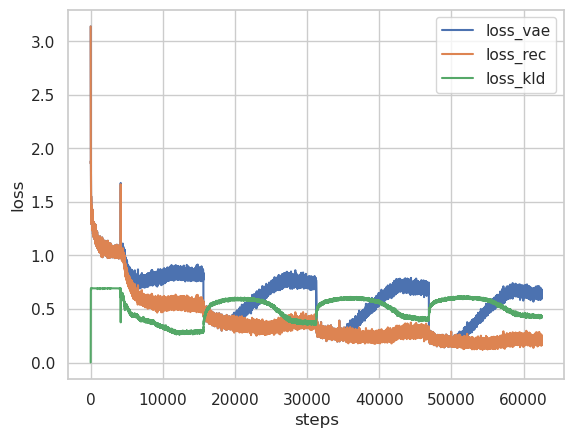

In [13]:
sns.set_theme(style='whitegrid')
ax = sns.lineplot(x=df_history.index, y=df_history['loss_vae'], err_style=None)
ax = sns.lineplot(x=df_history.index, y=df_history['loss_rec'], err_style=None, ax=ax)
ax = sns.lineplot(x=df_history.index, y=df_history['loss_kld'], err_style=None, ax=ax)

ax.legend(['loss_vae', 'loss_rec', 'loss_kld'])
ax.set_ylabel('loss')
ax.set_xlabel('steps')

# Random Sampling

In [7]:
tokenizer = SmilesEncoder((os.path.join(output_dir, 'vocabs.csv')))

Vocabulary size (including 3 special tokens): 23


In [8]:
new_generator = GumbelSmilesVAE(vocab_size=tokenizer.vocab_size,
                                embedding_size=16,
                                hidden_size=256,
                                latent_size=64,
                                sos_idx=tokenizer.sos_idx,
                                eos_idx=tokenizer.eos_idx,
                                pad_idx=tokenizer.pad_idx,
                                device=device)

new_generator.load_model(os.path.join(output_dir, 'ckpt.pt'))

In [9]:
rng = np.random.RandomState(2025)
latent_vectors = (rng.randn(10000,64) > 0).astype(np.float32)

generated = []
with torch.no_grad():
    for z in tqdm(latent_vectors):
        z = torch.tensor(z, device=device)
        smi = new_generator.inference(z)
        smi = tokenizer.decode([smi])[0]
        generated.append(smi)

df_gen = pd.DataFrame(generated, columns=['smiles'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:52<00:00, 191.78it/s]


# Validity Check

In [10]:
df_gen.loc[:,'canonical'] = ''
df_gen.loc[:,'valid'] = 0
df_gen = df_gen.astype({'valid':int})

In [11]:
for i in trange(len(df_gen)):
    smi = df_gen.loc[i,'smiles']
    mol = Chem.MolFromSmiles(smi)
    if mol:
        df_gen.loc[i,'canonical'] = Chem.MolToSmiles(mol, kekuleSmiles=True)
        df_gen.loc[i,'valid'] = 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5301.12it/s]


In [12]:
df_gen

,smiles,canonical,valid
0,C=C1C=NOC(OCC=C)=C1C=O,C=CCOC1=C(C=O)C(=C)C=NO1,1
1,C#CCNC1(CN(C)C)SC(=O)O1,C#CCNC1(CN(C)C)OC(=O)S1,1
2,C=C(C(=N)C(=N)N)C1=NOCC1=O,C=C(C(=N)C(=N)N)C1=NOCC1=O,1
3,C=CC(C)C1(O)COC2(CCS2)C1,C=CC(C)C1(O)COC2(CCS2)C1,1
4,CC=C1OC2C3CC4CN4CC2C13,CC=C1OC2C3CC4CN4CC2C13,1
...,...,...,...
9995,COCC(O)CN(C)N=CNC=N,COCC(O)CN(C)N=CNC=N,1
9996,C=NN(N)C1CCOC2CCC21C,C=NN(N)C1CCOC2CCC21C,1
9997,C=CC1C=CN(C=N)C1C(C)C=C,C=CC(C)C1C(C=C)C=CN1C=N,1
9998,C=CC(=N)NC(C=O)C(C)=COC,C=CC(=N)NC(C=O)C(C)=COC,1


In [13]:
df_gen['valid'].value_counts()

valid
1    9346
0     654
Name: count, dtype: int64

In [14]:
df_gen.to_csv(os.path.join(output_dir, 'generated.csv'), index=False)

# Evaluation

In [15]:
MetricEngine = GetMetrics(
    n_jobs=20,
    device='cpu',
    batch_size=512,
    run_fcd=False,
    train=dataset.df['smiles'].values.tolist(),
)

Cleaning up reference smiles


In [16]:
metrics = MetricEngine.calculate(
    df_gen['smiles'].values.tolist(),
    calc_valid=True,
    calc_unique=True,
    unique_k=10000,
    se_k=1000,
    sp_k=1000,
    verbose=True,
)

Calculating Validity & Uniqueness
Computing pre-statistics (fps, ring systems etc.)
Calculating Novelty
Calculating Diversity
Calculating Filters


In [17]:
metrics

{'#': 10000,
 'Validity': 0.9345,
 '# valid': 9345,
 'Uniqueness': 1.0,
 '# valid & unique': 9345,
 'Novelty': 0.9997859818084537,
 '# novel': 9343,
 'IntDiv1': 0.9038065353801495,
 'IntDiv2': 0.8970243566455017,
 'SEDiv@1k': 0.993,
 'SPDiv@1k': 0.9083269846974154,
 '# scaffolds': 4608,
 'ScaffDiv': 0.8961942575643426,
 'ScaffUniqueness': 0.4930979133226324,
 'FG': 0.23449770942408377,
 'RS': 0.45453616673477726,
 'Filters': 0.6340288924558587,
 'Purchasable_ZINC20': 0.0}